In [40]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from tqdm import tqdm

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading dataset
filename = 'datasets/processed/bank-train-encoded.csv'
df = pd.read_csv(filename, comment='#') # initially -opt4
try:
    df = df.drop('duration')
except KeyError:
    pass

In [4]:
# visualization is computationally expensive so I'll limit number of data points
# splits have to be stratified to guarantee preserving positive / negative ratio
max_datapoints = 7000
n_splits = np.ceil(len(df) / max_datapoints)
print(f'Splitting dataset into {n_splits} folds')
kfold = StratifiedKFold(n_splits=int(n_splits), shuffle=True, random_state=1024503) #, random_state=1024503
_, idxs = list(kfold.split(df.drop(columns=['y']), df['y']))[0]
print('1st fold contain {} data points'.format(len(idxs)))

Splitting dataset into 5.0 folds
1st fold contain 5767 data points


In [5]:
# settings for visualization subplots
n_components = 2
#datasets_options = [1, 4, 5, 10]
pps = [10, 50, 100]
subplot_size = (5, 5) # (width, height)

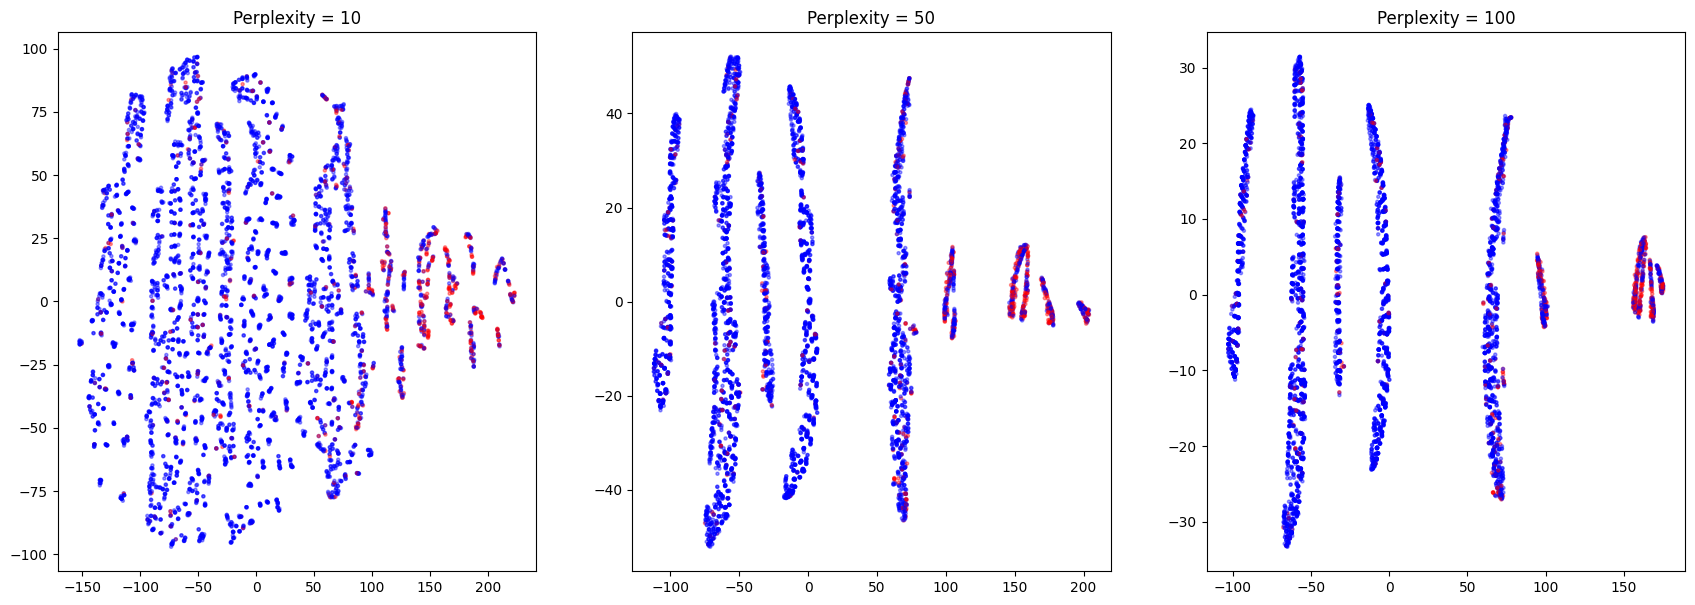

In [8]:
plots_cols = len(pps)
#plots_rows = len(datasets_options)
fig, axs = plt.subplots(1, plots_cols, figsize=(subplot_size[0]*plots_cols, subplot_size[1]))
tsnes = {}
for j, pp in tqdm(enumerate(pps)):
    tsne = TSNE(n_components=n_components, perplexity=pp, random_state=1028503, init='pca', learning_rate='auto', n_jobs=3) #, n_jobs=3
    tsne_res = tsne.fit_transform(df.drop(columns=['y']).iloc[idxs])
    tsnes[pp] = tsne_res.copy()
    axs[j].scatter(tsne_res[:, 0], tsne_res[:, 1], c=df['y'].iloc[idxs], s=5, cmap='bwr', alpha=0.4)
    axs[j].set_title(f'Perplexity = {pp}');

Here we can clearly see several clusters. In 2 clusters on the right the density of red points (positives) is higher than in other. But we can test it for sure

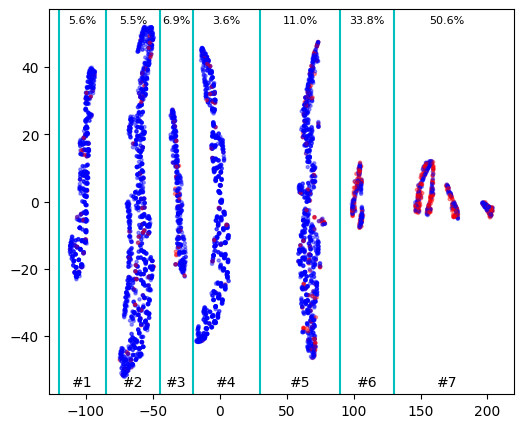

In [39]:
df_tsne = pd.DataFrame({'x': tsnes[pp][:, 0], 'y': tsnes[pp][:, 1], 'target': df['y'][idxs]}, index=idxs)
x_borders = [-120, -85, -45, -20, 30, 90, 130, 210]
pp = 50
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(tsnes[pp][:, 0], tsnes[pp][:, 1], c=df['y'].iloc[idxs], s=5, cmap='bwr', alpha=0.4)
for i in range(7):
    ax.axvline(x=x_borders[i], color='c')
    ax.text(x=(x_borders[i]+x_borders[i+1])/2, y=-55, s=f'#{i+1}', fontsize=8, ha='center')
    density = df_tsne.loc[(df_tsne['x'] > x_borders[i]) & (df_tsne['x'] < x_borders[i+1]), 'target'].mean()
    ax.text(x=(x_borders[i]+x_borders[i+1])/2, y=53, s=f'{density*100:.1f}%', fontsize=8, ha='center')

So the probability of positive outcome significantly varies between clusters and we can use this information to train correct clustering algorithm by choosing appropriate initial points. We can take, for example, points from clusters 1, 5, 6 and 7 and define number  of clusters as 4. Or we can take points from clusters 1, 5 and 7 and search for 3 clusters (most probably in this case clusters 5 and 6 will be united)

In [45]:
initial_points_idxs = [
    df_tsne[df_tsne['x'] < -85].index[0],
    df_tsne[(df_tsne['x'] > 30) & (df_tsne['x'] < 90)].index[0],
    df_tsne[df_tsne['x'] > 130].index[0]
]

kmeans = KMeans(n_clusters=3, init=[df.loc[i] for i in initial_points_idxs])
kmeans.fit(df)
df['cluster'] = kmeans.predict(df)
for i in range(3):
    density = df[df['cluster'] == i]['y'].mean()
    print(f'#{i+1} : {density*100:.1f}%')

#1 : 5.0%
#2 : 16.1%
#3 : 48.6%


In [46]:
df_test = pd.read_csv('datasets/processed/bank-train-encoded.csv', comment='#')
df_test['cluster'] = kmeans.predict(df_test)
for i in range(3):
    density = df_test[df_test['cluster'] == i]['y'].mean()
    print(f'#{i+1} : {density*100:.1f}%')

#1 : 5.0%
#2 : 16.1%
#3 : 48.6%
